## Created on Mon June 24 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load test gene expression dataset (GSE96058; Illumina Hiseq 2000 platform).
# The gene expression values were defined as log2(TPM + 1).
feature = pd.read_csv("/home/wjddns037/Code/Project_code/GPL11154_Feature.csv", sep = "\t")
feature.index = feature.loc[:, "Unnamed: 0"].tolist()
feature = feature.drop(columns = ["Unnamed: 0"])
feature.shape

(2770, 1703)

In [3]:
# Load test PAM50 dataset (GSE96058; Illumina Hiseq 2000 platform).
target = pd.read_csv("/home/wjddns037/Code/Project_code/GPL11154_PAM50.csv", sep = "\t")
target.index = target.loc[:, "Unnamed: 0"].tolist()
target = target.drop(columns = ["Unnamed: 0"])
target.shape

(2770, 1)

### Split gene expression and metadata into training and test dataset, respectively

In [4]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, 
                                                    stratify = target, random_state = 42)

# Z-score normalization on TPM-level data
# https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w
train_median = np.median(X_train, axis = 0)
train_std = np.std(X_train, axis = 0)

X_train_scale = (X_train - train_median) / train_std
X_test_scale = (X_test - train_median) / train_std

X_train = pd.DataFrame(X_train_scale, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(X_test_scale, index = X_test.index, columns = X_test.columns)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'PDE4B'),
  Text(1, 0, 'KCNH1'),
  Text(2, 0, 'CDC42BPA'),
  Text(3, 0, 'ZSWIM5'),
  Text(4, 0, 'GRIK3'),
  Text(5, 0, 'SPAG17'),
  Text(6, 0, 'TGFBR3'),
  Text(7, 0, 'KCND3'),
  Text(8, 0, 'PTPN14'),
  Text(9, 0, 'PTGER3')])

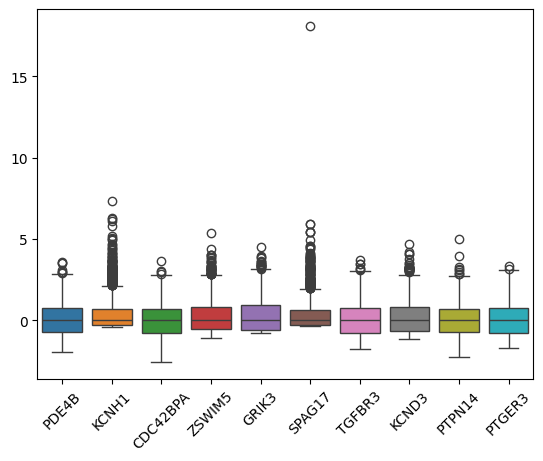

In [5]:
# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train.iloc[:, 0:10])
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'PDE4B'),
  Text(1, 0, 'KCNH1'),
  Text(2, 0, 'CDC42BPA'),
  Text(3, 0, 'ZSWIM5'),
  Text(4, 0, 'GRIK3'),
  Text(5, 0, 'SPAG17'),
  Text(6, 0, 'TGFBR3'),
  Text(7, 0, 'KCND3'),
  Text(8, 0, 'PTPN14'),
  Text(9, 0, 'PTGER3')])

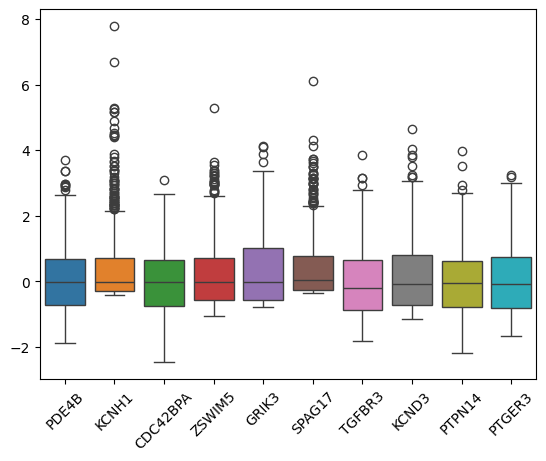

In [6]:
# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test.iloc[:, 0:10])
plt.xticks(rotation = 45)

In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit(y_test)

Text(0, 0.5, 'Frequency')

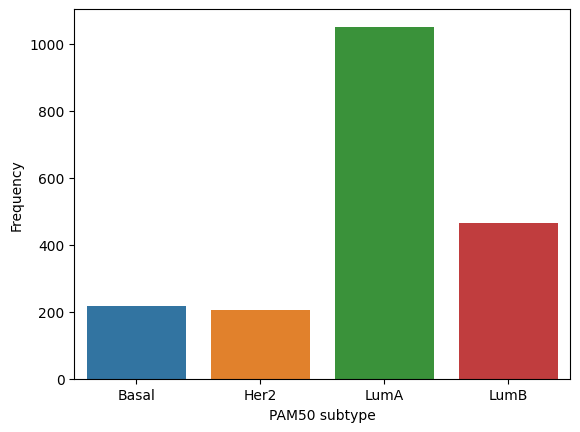

In [8]:
# Check count for each class in the training data.
class_counts = pd.Series(y_train).groupby(y_train).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

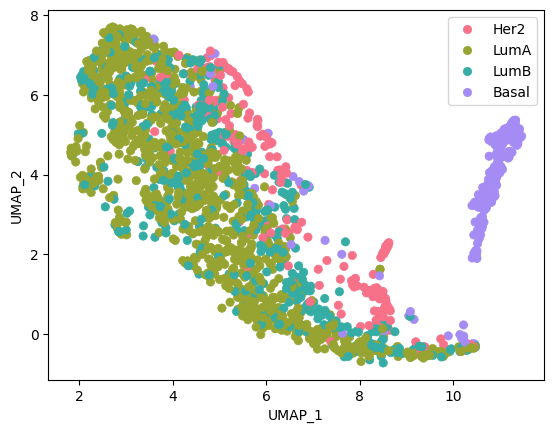

In [9]:
# Initialize UMAP
from umap import UMAP
plt.rcdefaults()

umap_2d = UMAP(n_components = 2, init = "random", random_state = 42)
proj_2d = umap_2d.fit_transform(X_train)
proj_2d = pd.DataFrame(proj_2d, columns = ["UMAP_1", "UMAP_2"])
proj_2d['PAM50'] = pd.Series(y_train).map({0: "Basal", 1: "Her2", 2: "LumA", 3: "LumB"})

# Plot using seaborn
sns.scatterplot(data = proj_2d, x = 'UMAP_1', y = 'UMAP_2', hue = 'PAM50', edgecolor = None, palette = "husl")
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.legend(loc = 'best')
plt.show()

### Feature selection using shapRFECV

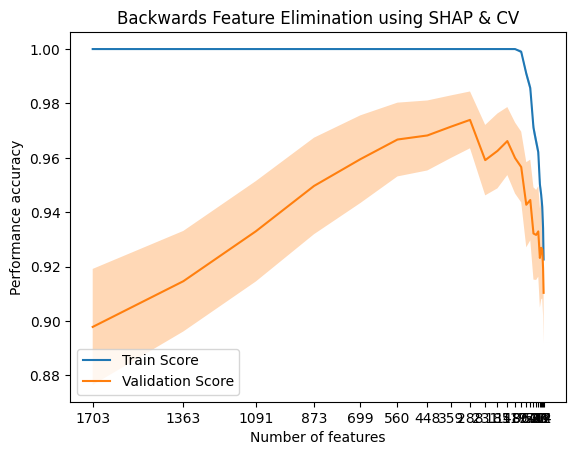

In [10]:
# shapRFECV based on random forest.
from sklearn.svm import SVC
from probatus.feature_elimination import ShapRFECV
plt.rcdefaults()
model = SVC(random_state = 42, probability = True, kernel = "linear")
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)

shap_elimination = ShapRFECV(model, step = 0.2, cv = cv, min_features_to_select = 12,
                             scoring = 'accuracy', n_jobs = 80, random_state = 42)
report = shap_elimination.fit_compute(X_train, y_train, check_additivity = False)
performance_plot = shap_elimination.plot()

In [11]:
# Inspect the report generated by ShapRFECV
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,1703,"[PDE4B, KCNH1, CDC42BPA, ZSWIM5, GRIK3, SPAG17...","[ADAMTS19, FBLIM1, HEBP2, CLK4, TFCP2, MSI1, S...",1.000000,0.000000,0.897840,0.021326
2,1363,"[PDE4B, KCNH1, CDC42BPA, ZSWIM5, GRIK3, SPAG17...","[DHX32, ODF2, VWDE, LDHD, ROGDI, CAND2, CACNG6...",1.000000,0.000000,0.914652,0.018488
3,1091,"[KCNH1, CDC42BPA, ZSWIM5, SPAG17, KCND3, PTPN1...","[PGRMC2, NAP1L5, AS3MT, DHRS4L2, UBL3, COCH, C...",1.000000,0.000000,0.933011,0.018456
4,873,"[KCNH1, ZSWIM5, KCND3, PTPN14, PTGER3, SUSD4, ...","[THBD, PDZK1IP1, FOXD1, MTFR1, ZNF395, TMEM150...",1.000000,0.000000,0.949670,0.017743
5,699,"[ZSWIM5, KCND3, PTGER3, SUSD4, EDARADD, CAPN8,...","[TBX1, ZNF471, ERICH1, MNX1, SMAD3, HPDL, ZNF3...",1.000000,0.000000,0.959520,0.016118
6,560,"[ZSWIM5, KCND3, PTGER3, SUSD4, EDARADD, ITPKB,...","[SPDYC, EFEMP1, SLPI, CYP2E1, MCTP2, FOXI1, S1...",1.000000,0.000000,0.966740,0.013560
7,448,"[ZSWIM5, KCND3, SUSD4, EDARADD, ITPKB, RAVER2,...","[NHLRC4, CHRNA5, FBXO27, MICB, SIK2, S100A16, ...",1.000000,0.000000,0.968234,0.012867
8,359,"[ZSWIM5, SUSD4, ITPKB, RAVER2, LRP8, PHGDH, TB...","[SLITRK5, DAZAP2, FAM24B, L3MBTL1, CYP4F22, IN...",1.000000,0.000000,0.971482,0.011489
9,288,"[SUSD4, ITPKB, RAVER2, LRP8, PHGDH, TBCE, WDTC...","[SAC3D1, SHISA9, PRR15, MTHFD1L, CISD3, FAM83B...",1.000000,0.000000,0.973958,0.010444
10,231,"[ITPKB, RAVER2, PHGDH, TBCE, WDTC1, ZNF695, TT...","[APOD, TBC1D9, GAL3ST2, GREB1, SCCPDH, PLAT, G...",1.000000,0.000000,0.959156,0.012951


In [12]:
# Inspect the features, which achive highest accuracy.
keep_gene = shap_elimination.get_reduced_features_set(num_features = 12)
df_keep_gene = pd.DataFrame(keep_gene, columns = ["Gene"])
df_keep_gene.shape

(12, 1)

In [13]:
# Select these features.
X_train = X_train.loc[:, keep_gene]
X_train.head()

,TMEM45B,KCNJ11,KRT5,CDH3,MAPT,TYMS,MYBL2,FAM83D,ESR1,FOXC1,NAT1,SFRP1
GSM2528830,-0.839013,-1.188420,-1.521892,-0.950804,-1.950219,-0.815762,0.258369,-0.112928,-1.740173,-0.888345,-1.169840,-1.533651
GSM2530511,0.116501,0.140412,-0.883743,-0.835087,0.445628,0.498224,-0.243297,0.026921,0.143596,0.328045,1.009660,0.472579
GSM2529478,0.732676,-0.115923,1.168818,1.034208,0.104822,-0.780848,-1.154596,-1.012543,-0.059827,0.929136,0.402659,2.546376
GSM2528452,1.367018,0.425640,0.254877,0.654309,0.487666,-0.435733,-0.507471,-0.610578,0.730833,0.061014,1.604981,0.267953
GSM2531266,0.655727,0.805652,0.405251,-0.416042,-0.879007,1.256286,0.435536,0.401366,0.989218,-0.091672,-0.537058,0.298557


In [14]:
# Select these features.
X_test = X_test.loc[:, keep_gene]
X_test.head()

,TMEM45B,KCNJ11,KRT5,CDH3,MAPT,TYMS,MYBL2,FAM83D,ESR1,FOXC1,NAT1,SFRP1
GSM2530931,-0.859323,-0.351465,0.207017,-0.274760,-1.541938,0.513155,0.677217,0.321014,1.095064,0.189007,1.351697,-0.023451
GSM2528314,-1.329694,-1.872426,-0.510701,1.344980,-1.020496,-0.453156,1.084912,1.114391,-2.150182,2.154276,-1.539682,1.456621
GSM2528222,-1.302585,-1.574218,1.020903,1.707660,-1.763854,0.464072,1.429975,1.030279,-2.121962,2.556762,-1.547923,1.459707
GSM2531033,0.837316,0.606225,0.179726,-0.111490,0.535218,0.378999,-0.566301,-0.453993,-0.737661,-0.013472,0.502547,0.474303
GSM2529552,-0.668755,0.372996,-0.454090,-0.686806,-0.092932,1.867069,2.107787,1.805055,0.330358,-0.505014,0.822713,-0.790687


In [15]:
# Save train dataset
X_train.to_csv("/home/wjddns037/Code/Project_code/X_train_feature_select.csv", sep = "\t")

In [16]:
# Save test dataset
X_test.to_csv("/home/wjddns037/Code/Project_code/X_test_feature_select.csv", sep = "\t")

In [17]:
# Save report
report.to_excel("/home/wjddns037/Code/Project_code/shapRFECV_report.xlsx")

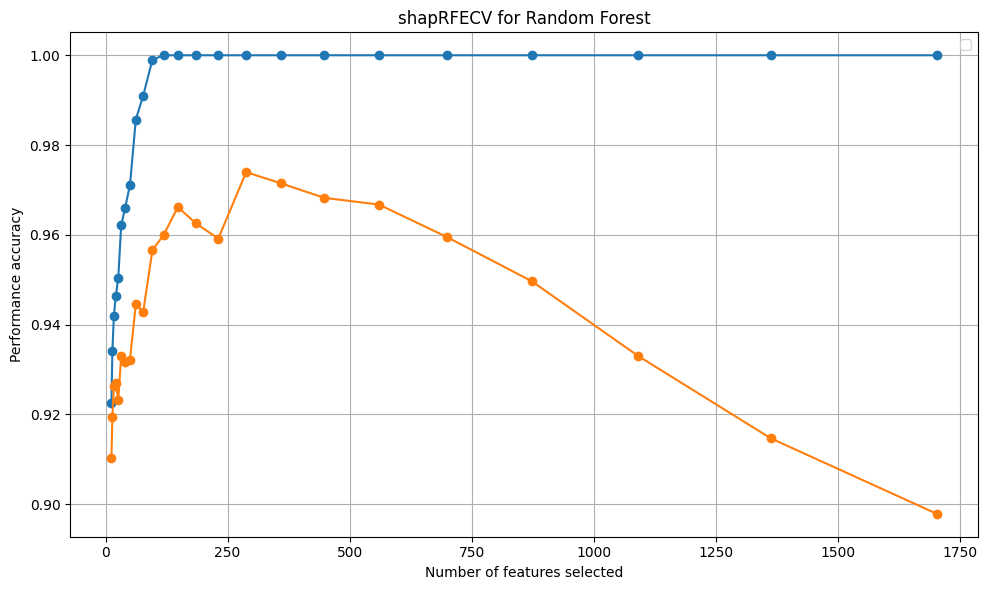

In [18]:
# 데이터 준비
num_features = report["num_features"]
train_metric_mean = report["train_metric_mean"]
val_metric_mean = report["val_metric_mean"]

# 시각화
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(num_features, train_metric_mean, marker="o", linestyle='-')
plt.plot(num_features, val_metric_mean, marker="o", linestyle='-')

plt.xlabel("Number of features selected")
plt.ylabel("Performance accuracy")
plt.title("shapRFECV for Random Forest")
plt.grid(True)  # Add grid lines

plt.legend(loc='best')  # Adjust legend location if needed
plt.tight_layout()  # Adjust spacing to prevent labels from being cut off

plt.show()

### Z-score Normalization on external dataset

In [19]:
# Load test gene expression dataset (GSE81538).
# The gene expression values were defined as log2(TPM + 1).
GSE81538_feature = pd.read_csv("/home/wjddns037/Code/Project_code/GSE81538_Feature.csv", sep = "\t")
GSE81538_feature.index = GSE81538_feature.loc[:, "Unnamed: 0"].tolist()
GSE81538_feature = GSE81538_feature.drop(columns = ["Unnamed: 0"])

GSE81538_feature_scale = (GSE81538_feature - train_median) / train_std
GSE81538_feature = pd.DataFrame(GSE81538_feature_scale, index = GSE81538_feature.index, columns = GSE81538_feature.columns)

In [20]:
# Load test gene expression dataset (GSE135298).
# The gene expression values were defined as log2(TPM + 1).
GSE135298_feature = pd.read_csv("/home/wjddns037/Code/Project_code/GSE135298_Feature.csv", sep = "\t")
GSE135298_feature.index = GSE135298_feature.loc[:, "Unnamed: 0"].tolist()
GSE135298_feature = GSE135298_feature.drop(columns = ["Unnamed: 0"])

GSE135298_feature_scale = (GSE135298_feature - train_median) / train_std
GSE135298_feature = pd.DataFrame(GSE135298_feature_scale, index = GSE135298_feature.index, columns = GSE135298_feature.columns)

In [21]:
# Load test gene expression dataset (GPL18573).
# The gene expression values were defined as log2(TPM + 1).
GPL18573_feature = pd.read_csv("/home/wjddns037/Code/Project_code/GPL18573_Feature.csv", sep = "\t")
GPL18573_feature.index = GPL18573_feature.loc[:, "Unnamed: 0"].tolist()
GPL18573_feature = GPL18573_feature.drop(columns = ["Unnamed: 0"])

GPL18573_feature_scale = (GPL18573_feature - train_median) / train_std
GPL18573_feature = pd.DataFrame(GPL18573_feature_scale, index = GPL18573_feature.index, columns = GPL18573_feature.columns)

In [22]:
# Save dataset.
GSE81538_feature.to_csv("/home/wjddns037/Code/Project_code/GSE81538_feature_scale.csv", sep = "\t")
GSE135298_feature.to_csv("/home/wjddns037/Code/Project_code/GSE135298_feature_scale.csv", sep = "\t")
GPL18573_feature.to_csv("/home/wjddns037/Code/Project_code/GPL18573_feature_scale.csv", sep = "\t")